In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile
import skimage
import pyvips
from skimage import io, transform
from scipy import ndimage as nd
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.unet import Unet
import sys
from sklearn.model_selection import GroupKFold
import time

In [2]:
from albumentations import (
    Compose,
    OneOf,
    Flip,
    Rotate,
    RandomRotate90,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    GaussianBlur,
    GaussNoise,
    RandomCrop,
    ShiftScaleRotate,
    VerticalFlip,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomScale,
    OpticalDistortion,
    ElasticTransform,
)

In [3]:


BASE_PATH = "./"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
DATA_PATH = os.path.join(BASE_PATH,"processed")


In [4]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [5]:


df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub



,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [6]:


df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)



,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
6,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
2,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
12,2f6ecfcdf.tiff,25794,31278,2f6ecfcdf-anatomical-structure.json,2f6ecfcdf.json,68555,White,Not Hispanic or Latino,Female,76,93.0,157.4,37.5,Left,80,20


# EDA

In [7]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [ ]:
def getSingleFTU(mask):
    '''
    divides a mask for one pic into many masks each containing single FTU mask
    not used now
    '''
    labels, nlabels = nd.label(mask)
    label_masks = []
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        #label_masks.append(label_mask)
        yield label_mask
def getFTUs(image,mask):
    '''
    from an image and a mask, get list of images of FTUs
    '''
    ftus = []
    labels, nlabels = nd.label(mask)
    for label_ind, label_coords in enumerate(nd.find_objects(labels)):
        cell = image[label_coords]
        ftus.append(cell)
    return ftus

In [ ]:
#plot random selection of FTUs from an image
indices = np.random.randint(len(ftus), size=(10))
ftus_selection = np.array(ftus)[indices]

for i,image in zip(indices,ftus_selection):
    plt.figure()
    plt.imshow(image)
    plt.title('label = {}'.format(i), fontsize=8)

# DATALOADER

In [8]:
# needed to transform pyvips.Image to ndarray
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

In [9]:
def show_kidney(image, mask, alpha = 0.5):
    """Show image with mask"""
    #if image.shape[0] == 0 
    if type(image) == torch.Tensor:
        plt.imshow(image.permute(1,2,0))
    #if type(image) == nd.array:
       # plt.imshow(image.transpose(1,2,0))
    plt.imshow(mask[0,...].numpy(), cmap="hot", alpha=alpha)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [10]:
# tutorial can be found here:
# https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
# class to load one pic
class KidneyFTUsDataset(Dataset):
    '''
    Kdiney with FTU mask dataset
    '''
    def __init__(self, root_dir, csv_file, mask_file, name_df = None, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with pic names.
            mask_file (string): hdf5 file containing masks 
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        if name_df is not None:
            self.name_list = name_df
        else:
            self.name_list = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.mask_file = h5py.File(os.path.join(self.root_dir, mask_file), 'r')
        if transform is not None:
            self.transform = transform
        else:
            self.transform = self.__transform_default()
            
    def __len__(self):
        return len(self.name_list)
    
    def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            tile_name = self.name_list.iloc[idx]['name']
            mask = self.mask_file[tile_name][()]
            image = tifffile.imread(os.path.join(self.root_dir, 
                                                 tile_name + '.tiff'))
            
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            image = torch.Tensor(image).permute(2, 0, 1)
            mask = torch.Tensor(mask).unsqueeze(0)
            
            sample = {'image': image, 'mask': mask}
            return sample
        
    def __transform_default(self):
        return Compose([
            Normalize(max_pixel_value=255.0),
        ])
        




## check that custom dataset class actually does something

In [11]:
ftu_dataset = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                csv_file = 'names.csv', 
                                mask_file = 'mask.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


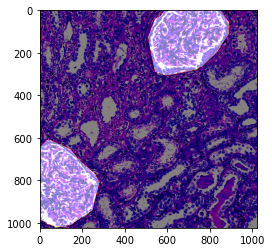

In [12]:
sample = ftu_dataset[2900]
show_kidney(**sample)

## Transformations

In [13]:
aug_train = Compose([Flip(p=0.5),
                     RandomRotate90(p=0.5),
                     Rotate(limit=180, p=0.5),
                     Normalize(max_pixel_value=255.0),
        ])

## check transforms are actually doing something

In [14]:
transformed_dataset = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                        csv_file = 'names.csv', 
                                        mask_file = 'mask.h5',
                                        transform=aug_train
                                           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


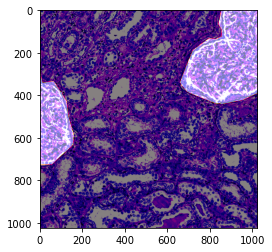

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


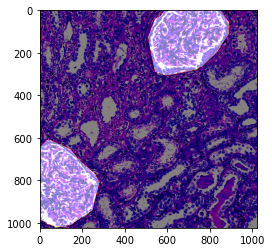

In [15]:
ind = 2900
show_kidney(**transformed_dataset[ind])
show_kidney(**ftu_dataset[ind])

In [19]:
dataloader = DataLoader(ftu_dataset, batch_size=4,
                        shuffle=True, num_workers=1)

In [20]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df.loc[~df.Folds.isin(fold)]
    val_ids = df.loc[df.Folds.isin(fold)]
    train_ds = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                        csv_file = 'names.csv', 
                                        mask_file = 'mask.h5',
                                        name_df = train_ids,
                                        transform=aug_train)
    val_ds = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                        csv_file = 'names.csv', 
                                        mask_file = 'mask.h5',
                                        name_df = val_ids,
                                        transform=aug_train)
    train_loader = DataLoader(train_ds, batch_size=12, 
                              pin_memory=True, shuffle=True, 
                              num_workers=1)
    val_loader = DataLoader(val_ds, batch_size=4, 
                            pin_memory=True, shuffle=False, 
                            num_workers=1)
    return train_loader, val_loader

0 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
1 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
2 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


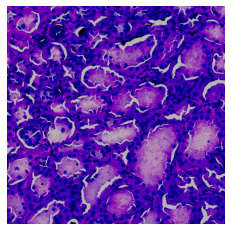

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


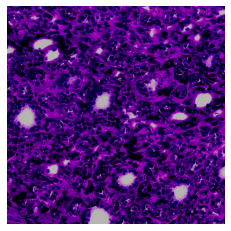

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


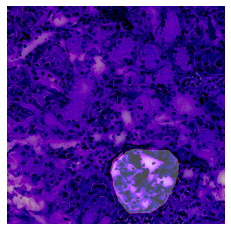

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


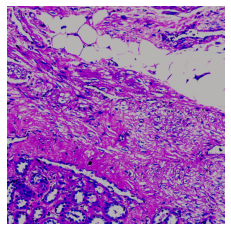

In [21]:
# Helper function to show a batch
def show_mask_batch(sample_batched):
    """Show image with masks for a batch of samples."""
    images_batch, masks_batch = \
            sample_batched['image'], sample_batched['mask']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    
    grid1 = utils.make_grid(masks_batch)
    plt.imshow(grid1.numpy().T)

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        
        plt.figure()
        for i,im in enumerate(sample_batched['image']):
            plt.axis('off')
            plt.ioff()
            plt.imshow(im.permute(1,2,0))
            plt.imshow(sample_batched['mask'][i].numpy().transpose(1,2,0)[...,0],cmap = 'hot', alpha = 0.3)
            plt.show()
        break

# MODEL

In [22]:
class HuBMAP(torch.nn.Module):
    def __init__(self):
        super(HuBMAP, self).__init__()
        self.cnn_model = Unet('efficientnet-b5', encoder_weights="imagenet", classes=1, activation=None)
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    
    def forward(self, imgs):
        img_segs = self.cnn_model(imgs)
        return img_segs

In [23]:
# https://github.com/qubvel/segmentation_models.pytorch
model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 3,
    classes = 1,
    activation = 'sigmoid'
)

# LOSS

In [24]:
# https://www.kaggle.com/vineeth1999/hubmap-pytorch-efficientunet-offline
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice

class DiceBCELoss(torch.nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()    

# Train func

In [25]:
def HuBMAPLoss(images, targets, model, device):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    criterion = DiceBCELoss()
    loss = criterion(outputs, targets)
    return loss, outputs

In [26]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    for step, dic in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(dic['image'], dic['mask'], model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )

            
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    for step, dic in enumerate(validloader):
        loss, outputs = HuBMAPLoss(dic['image'], dic['mask'], model, device)
        loss = loss.detach().item()
        total_loss += loss
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'epoch {epoch} trainz step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )

In [27]:
dir_df = pd.read_csv(os.path.join(DATA_PATH, 'names.csv'))
dir_df['Folds'] = 0

In [28]:
FOLDS = 5
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold

In [ ]:
dir_df

In [29]:

for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    if fold>0:
        break
    
    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HuBMAP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)
    #num_epochs = 15
    num_epochs = 1
    for epoch in range(num_epochs):
    
        train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        
        with torch.no_grad():
            valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
    torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')
    break



Traceback (most recent call last):
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/alcauchy/anaconda3/envs/kaggle/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 